# Example Fit 1D using tau_upperlimitstools_fitting module

In [1]:
import ROOT

Welcome to JupyROOT 6.26/02


In [2]:
import tau_upperlimitstools_fitting as tau_tools

### Create input histograms

In [3]:
h1sig=tau_tools.create_gauss_histogram_1D( gauss_mean = 5,
                                      gauss_sigma= 1,
                                      gauss_events = 2000,
                                      hist_ranges = [0,10],
                                      hist_name = "x_sig",
                                      hist_bins=100 )

h1bkg=tau_tools.create_exponential_histogram_1D(exp_scale=4,
                                           exp_events = 2000,
                                           hist_ranges = [0,10],
                                           hist_name = "x_bkg",
                                           hist_bins=100 )

Cheking distributions

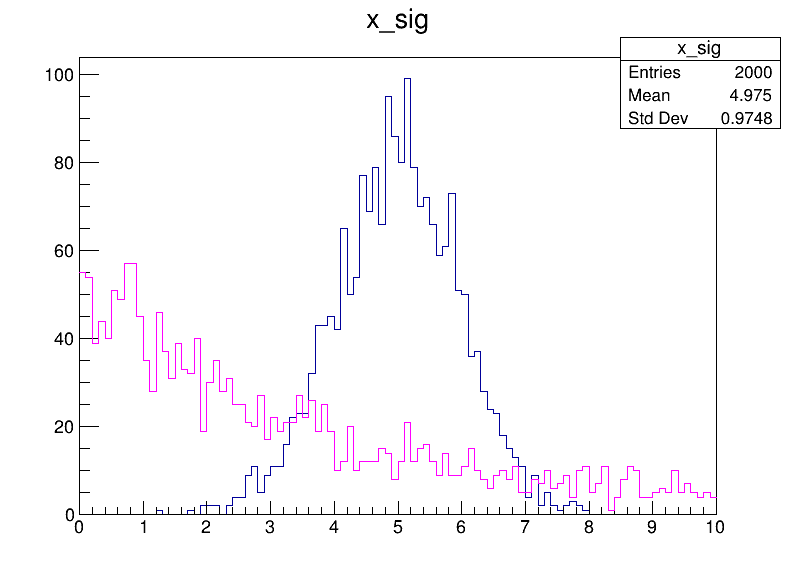

In [4]:
h1bkg.SetLineColor(6)
canvas_0 = ROOT.TCanvas("canvas_0","canvas_0", 800, 600)
h1sig.Draw("")
h1bkg.Draw("same")
canvas_0.Draw()

### Specification of the extended s+b model  (from histogram templates)

In [5]:
model_configuration={'model_sb': {'signal': 
                                        {'histogram':h1sig, 
                                         'pdf_name':'signal_pdf', 
                                         'nsig_yield_range':'[-20,1000]'}, 
                                  'background':{'histogram':h1bkg, 
                                                'pdf_name':'background_pdf',
                                                'nbkg_yield_range':'[-10,3000]'},
                                  'variables_names':['x'],
                                  'variables_ranges':['[0,10]'],
                                  'dimension':"1D",
                                  'pseudo_data_yields':{'n_sig':1, 'n_bkg':2000}
                                 }
                    }

In [6]:
# Create the workspace given the dictionary created before
mywspace = tau_tools.create_workspace_extended(model_configuration)

Creating HistPDFs
Creating model in WorkSpace
[#1] INFO:ObjectHandling -- RooWorkspace::import(myWorkSpace) importing dataset datahist_vars_signal
[#1] INFO:ObjectHandling -- RooWorkspace::import(myWorkSpace) importing RooHistPdf::signal_pdf
[#1] INFO:ObjectHandling -- RooWorkspace::import(myWorkSpace) importing dataset datahist_vars_background
[#1] INFO:ObjectHandling -- RooWorkspace::import(myWorkSpace) importing RooHistPdf::background_pdf


In [7]:
mywspace.Print()


RooWorkspace(myWorkSpace) myWorkSpace contents

variables
---------
(n_bkg,n_sig,x)

p.d.f.s
-------
RooHistPdf::background_pdf[ pdfObs=(x) ] = 120
RooAddPdf::model_sb[ n_sig * signal_pdf + n_bkg * background_pdf ] = 287.859
RooHistPdf::signal_pdf[ pdfObs=(x) ] = 800

embedded datasets (in pdfs and functions)
-----------------------------------------
RooDataHist::datahist_vars_signal(x)
RooDataHist::datahist_vars_background(x)



### Configuration

In [8]:
# Add model configuration to the workspace
mywspace = tau_tools.model_configuration_extended(mywspace, model_configuration['model_sb']['dimension'])

In [9]:
mywspace.Print()


RooWorkspace(myWorkSpace) myWorkSpace contents

variables
---------
(n_bkg,n_sig,x)

p.d.f.s
-------
RooHistPdf::background_pdf[ pdfObs=(x) ] = 120
RooAddPdf::model_sb[ n_sig * signal_pdf + n_bkg * background_pdf ] = 287.859
RooHistPdf::signal_pdf[ pdfObs=(x) ] = 800

embedded datasets (in pdfs and functions)
-----------------------------------------
RooDataHist::datahist_vars_signal(x)
RooDataHist::datahist_vars_background(x)

named sets
----------
ModelConfig_NuisParams:(n_bkg)
ModelConfig_Observables:(x)
ModelConfig_POI:(n_sig)

generic objects
---------------
RooStats::ModelConfig::ModelConfig



### Pseudo Data generation

In [10]:
model_configuration

{'model_sb': {'signal': {'histogram': <cppyy.gbl.TH1D object at 0x55cdb1028180>,
   'pdf_name': 'signal_pdf',
   'nsig_yield_range': '[-20,1000]'},
  'background': {'histogram': <cppyy.gbl.TH1D object at 0x55cdb10a7600>,
   'pdf_name': 'background_pdf',
   'nbkg_yield_range': '[-10,3000]'},
  'variables_names': ['x'],
  'variables_ranges': ['[0,10]'],
  'dimension': '1D',
  'pseudo_data_yields': {'n_sig': 1, 'n_bkg': 2000}}}

In [11]:
# Generate pseudo data given the initial number of events as given in the `yield_values` dictionary
mywspace = tau_tools.generate_pseudodata_fromW(mywspace, 
                                          dimension = model_configuration['model_sb']['dimension'],
                                          yield_values= model_configuration['model_sb']['pseudo_data_yields'], 
                                          data_binned=True)

[#1] INFO:ObjectHandling -- RooWorkspace::import(myWorkSpace) importing dataset pseudo_data
[#1] INFO:ObjectHandling -- RooWorkspace::import(myWorkSpace) importing dataset pseudo_data_binned


In [12]:
# Now you see the `pseudo_data` <RooDataSet> and `pseudo_data_binned` <RooDataHist>
mywspace.Print()


RooWorkspace(myWorkSpace) myWorkSpace contents

variables
---------
(n_bkg,n_sig,x)

p.d.f.s
-------
RooHistPdf::background_pdf[ pdfObs=(x) ] = 120
RooAddPdf::model_sb[ n_sig * signal_pdf + n_bkg * background_pdf ] = 120.34
RooHistPdf::signal_pdf[ pdfObs=(x) ] = 800

datasets
--------
RooDataSet::pseudo_data(x)
RooDataHist::pseudo_data_binned(x)

embedded datasets (in pdfs and functions)
-----------------------------------------
RooDataHist::datahist_vars_signal(x)
RooDataHist::datahist_vars_background(x)

named sets
----------
ModelConfig_NuisParams:(n_bkg)
ModelConfig_Observables:(x)
ModelConfig_POI:(n_sig)

generic objects
---------------
RooStats::ModelConfig::ModelConfig



Note: 
<br>
After setting the values for generate_pseudodata_fromW, this will be the initial points for the FIT

In [13]:
print(mywspace.var("n_sig").getVal())
print(mywspace.var("n_bkg").getVal())

1.0
2000.0


### Fit to the pseudo_data

In [14]:
pdf = mywspace.pdf('model_sb')
data=mywspace.data("pseudo_data")
#Specify configuration for fitting, default minuit/migrat y strategy 1
fitResult = pdf.fitTo(data,
                      ROOT.RooFit.Extended(True),
                      ROOT.RooFit.Minos(True),
                      ROOT.RooFit.SumW2Error(False), 
                      ROOT.RooFit.Save(True), 
                      ROOT.RooFit.NumCPU(12),
                      ROOT.RooFit.PrintLevel(-1))

[#1] INFO:Minimization -- createConstraintTerm: caching constraint set under name CACHE_CONSTR_OF_PDF_model_sb_FOR_OBS_x with 0 entries
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 12 remote server process.
[#1] INFO:Minimization --  The following expressions have been identified as constant and will be precalculated and cached: (signal_pdf,background_pdf)
[#1] INFO:Minimization --  The following expressions have been identified as constant and will be precalculated and cached: (signal_pdf,background_pdf)
[#1] INFO:Minimization --  The following expressions have been identified as constant and will be precalculated and cached: (signal_pdf,background_pdf)
[#1] INFO:Minimization --  The following expressions have been identified as constant and will be precalculated and cached: (signal_pdf,background_pdf)
[#1] INFO:Minimization --  The following expressions have been identified as 

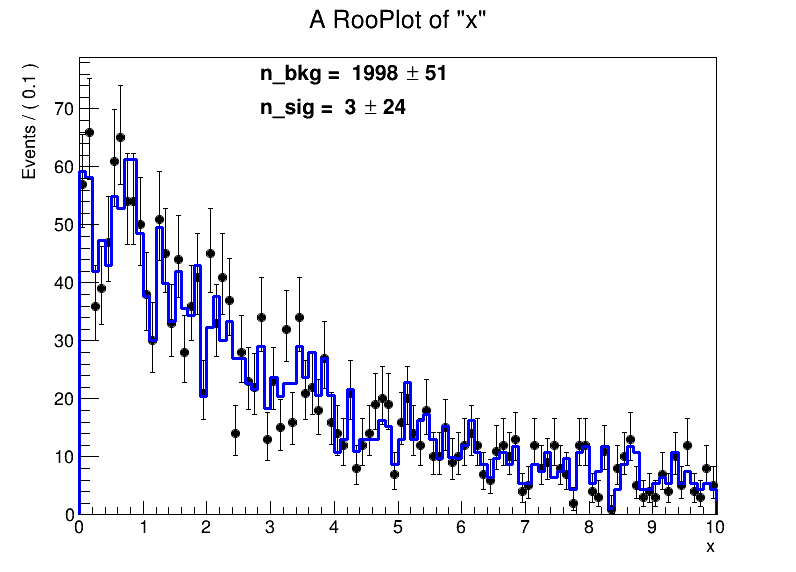

In [15]:
c3 = ROOT.TCanvas("DataHist","DataHist", 800, 600)
frame = mywspace.var('x').frame()
data.plotOn(frame)
pdf.plotOn(frame)
pdf.paramOn(frame,ROOT.RooFit.Layout(0.32, 0.47, 0.9))
frame.Draw()
c3.Draw()

In [16]:
fitResult.Print()


  RooFitResult: minimized FCN value: -9137.93, estimated distance to minimum: 8.85661e-06
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 MINOS=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                 n_bkg    1.9979e+03 +/-  5.08e+01
                 n_sig    2.9864e+00 +/-  2.40e+01



Note: 
<br>
After the fit n_sig is updated, this will be the value in the workspace.

In [17]:
tau_tools.check_status_fit(fitResult)

-------------------------------------------
A small edm value indicates effective convergence of the fit.
edm 8.856612252851881e-06 

A low minNll value indicates a successful fit finding a good description for the data.
minNll -9137.931623276341 

A value of 0 typically indicates a successful fit.
status 0 

A high covQual value (3) indicates good quality of the covariance matrix.
covQual 3 

A value of 0 suggests that all likelihood evaluations were valid.
numInvalidNll 0 

--------------------------------------------


### Save the workspace in a root file

In [18]:
#Save the WorkSpace in a root file to used later
tau_tools.save_myworkspace_infile(mywspace)

Workspace saved to workspace_model_sb.root with the name myWorkSpace
